In [ ]:
#pip install pandas

In [ ]:
#pip install numpy

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')  
os.chdir("/content/drive/My Drive/Colab Notebooks/Product/data")
sys.path.append("/content/drive/My Drive/Colab Notebooks/Product/data")

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import pytz as tz
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

In [ ]:
data = pd.read_csv('Gowalla_totalCheckins.txt', sep='\t', header=None)
data.columns = ['userid','timestamp','latitude','longitude','spotid']

In [ ]:
data.head(3)

,userid,timestamp,latitude,longitude,spotid
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637


In [ ]:
lon_min, lat_min, lon_max, lat_max = -74.2589, 40.4774, -73.7004, 40.9176
events = data[(data['longitude']>lon_min) & 
           (data['longitude']<lon_max) & 
           (data['latitude']>lat_min) & 
           (data['latitude']<lat_max)]
events.head()

,userid,timestamp,latitude,longitude,spotid
10,0,2010-10-12T00:21:28Z,40.643885,-73.782806,23261
11,0,2010-10-11T20:21:20Z,40.741374,-73.988105,16907
12,0,2010-10-11T20:20:42Z,40.741388,-73.989455,12973
13,0,2010-10-11T00:06:30Z,40.724910,-73.994621,341255
14,0,2010-10-10T22:00:37Z,40.729768,-73.998535,260957


In [ ]:
events.shape

(138957, 5)

In [ ]:
venue = pd.read_csv('spots.txt', sep='\t', header=0)

In [ ]:
venue.head(3)

,spotid,spotname,geo-coordinates
0,1391604,Conference House Park,POINT(-74.2523431778 40.5017589436)
1,1391611,Almer G. Russell Pavilion,POINT(-74.2542636395 40.5022647413)
2,3612422,Conference House,POINT(-74.2490418254 40.5000644614)


In [ ]:
#Time Zone Parsing

In [ ]:
def parse_datetime(s):
    tzone = tz.timezone("America/New_York") #parse_datetime
    utc = datetime.strptime(s, '%Y-%m-%dT%H:%M:%SZ')
    return tz.utc.localize(utc).astimezone(tzone)

In [ ]:
#Feature Engineering

In [ ]:
events['ts'] = events['timestamp'].apply(lambda x: parse_datetime(x))
events = events.drop('timestamp',axis=1,errors='ignore')

#local date and time
events['date']  = events['ts'].astype(object).apply(lambda x : x.date())
events['time']  = events['ts'].astype(object).apply(lambda x : x.time())

#day of the week (localtime)
#hour of the day (localtime)
events['weekday']  = events['date'].astype(object).apply(lambda x : x.weekday())
events['day']   = events['date'].astype(object).apply(lambda x : x.day)
events['hour']   = events['time'].astype(object).apply(lambda x : x.hour)

events[['ts','date','time','weekday','day','hour']][0:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ts,date,time,weekday,day,hour
10,2010-10-11 20:21:28-04:00,2010-10-11,20:21:28,0,11,20
11,2010-10-11 16:21:20-04:00,2010-10-11,16:21:20,0,11,16
12,2010-10-11 16:20:42-04:00,2010-10-11,16:20:42,0,11,16
13,2010-10-10 20:06:30-04:00,2010-10-10,20:06:30,6,10,20
14,2010-10-10 18:00:37-04:00,2010-10-10,18:00:37,6,10,18


In [ ]:
#Combining Events and Venue Data

In [ ]:
event1 = pd.DataFrame.merge(events, venue[['spotid','spotname']], on='spotid', how="inner")

In [ ]:
event1.head()

,userid,latitude,longitude,spotid,ts,date,time,weekday,day,hour,spotname
0,0,40.643885,-73.782806,23261,2010-10-11 20:21:28-04:00,2010-10-11,20:21:28,0,11,20,JFK John F. Kennedy International
1,0,40.643885,-73.782806,23261,2010-10-07 11:27:40-04:00,2010-10-07,11:27:40,3,7,11,JFK John F. Kennedy International
2,5,40.643885,-73.782806,23261,2010-08-15 23:47:20-04:00,2010-08-15,23:47:20,6,15,23,JFK John F. Kennedy International
3,8,40.643885,-73.782806,23261,2010-10-06 16:23:14-04:00,2010-10-06,16:23:14,2,6,16,JFK John F. Kennedy International
4,15,40.643885,-73.782806,23261,2010-10-13 00:10:36-04:00,2010-10-13,00:10:36,2,13,0,JFK John F. Kennedy International


In [ ]:
#Visual exploratory Data Analytics 

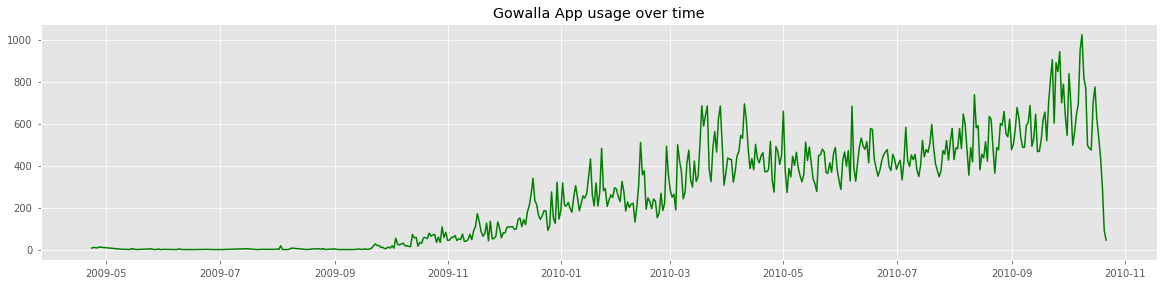

In [ ]:
# Let us plot the events registered, ordered temporally by increasing timestamps and grouped by date
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'
plt.style.use('ggplot')

plt.subplot(4, 1, 1)
top = events.groupby('date').size()
plt.plot(top.index, top, 'g-')
plt.title('Gowalla App usage over time')
plt.show()

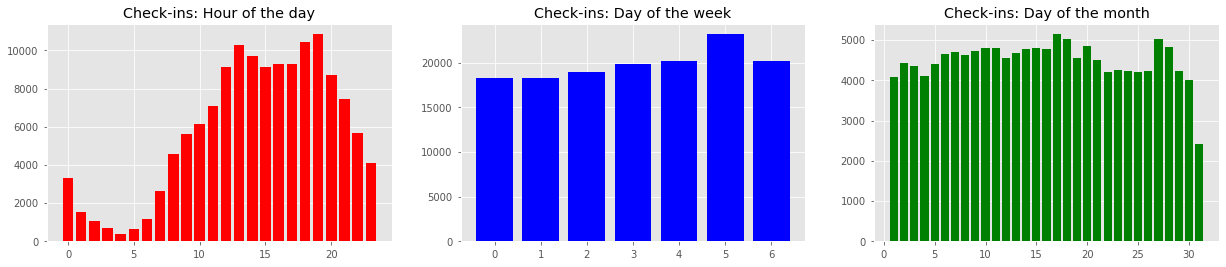

In [ ]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,4)
plt.subplot(1, 3, 1)
top = events.groupby('hour').size()
plt.bar(top.index, top,align='center', color='red')
plt.title('Check-ins: Hour of the day')
plt.subplot(1, 3, 2)
top = events.groupby('weekday').size()
plt.bar(top.index, top,align='center',color='blue')
plt.title('Check-ins: Day of the week')
plt.subplot(1, 3, 3)
top = events.groupby('day').size()
plt.bar(top.index, top,align='center',color='green')
plt.title('Check-ins: Day of the month')
plt.show()

In [ ]:
#Finding clusters in the NYC events dataset

In [ ]:
#for k in range(200, 270, 10):
    #kmeans = KMeans(n_clusters=k, init='k-means++')
    #X_sample = (nyc_events[['longitude','latitude']].sample(frac=0.1))
    #kmeans.fit(X_sample)
    #y = kmeans.labels_
    #print("k =", k, " silhouette_score ", silhouette_score(X_sample, y, metric='euclidean'))

# Rule of thumb for k: sqrt(n/2); here n is 112390 - total no. of NYC events
kmeans = KMeans(n_clusters=240, init='k-means++')

# Compute the clusters based on longitude and latitude features
X_sample = events[['longitude','latitude']].sample(frac=0.1)
kmeans.fit(X_sample)
y = kmeans.labels_
print("k = 240", " silhouette_score ", silhouette_score(X_sample, y, metric='euclidean'))

k = 240  silhouette_score  0.43646067931772137


In [ ]:
events['cluster'] = kmeans.predict(events[['longitude','latitude']])
events[['userid','latitude','longitude','spotid','cluster']].sample(10)

,userid,latitude,longitude,spotid,cluster
489236,1786,40.723014,-74.003456,26196,93
2909493,36188,40.691247,-74.179516,24963,3
4959160,109639,40.713936,-73.944239,255343,12
4127209,79128,40.731007,-73.988553,199847,13
4416857,96782,40.728728,-73.986254,53540,130
4010890,71159,40.782078,-73.981354,759100,59
1314977,6951,40.714785,-74.044247,1369703,56
4065685,74226,40.782938,-73.952762,599760,11
1670981,11577,40.725576,-73.999562,593918,123
2913053,36344,40.758202,-73.992316,997912,197


In [ ]:
#venue based on counts

In [ ]:
gdf = events.groupby(['cluster', 'spotid']).size().reset_index()
gdf.columns = ['cluster', 'spotid', 'count']
idx = gdf.groupby(['cluster'])['count'].transform(max) == gdf['count']
topvenues_df = gdf[idx].merge(venue, on='spotid', how='left').sort_values(by='count', ascending=False)
#top 10 out of 200 clusters by events count
topvenues = topvenues_df[:10]

In [ ]:
topvenues.head(3)

,cluster,spotid,count,spotname,geo-coordinates
22,22,12505,1680,LGA LaGuardia Airport,POINT(-73.8720059395 40.7745781069)
156,145,23261,1654,JFK John F. Kennedy International,POINT(-73.7828063965 40.6438845363)
227,210,11844,1089,Times Square,POINT(-73.9862251282 40.7568799674)


In [ ]:
#Most Popular Venues

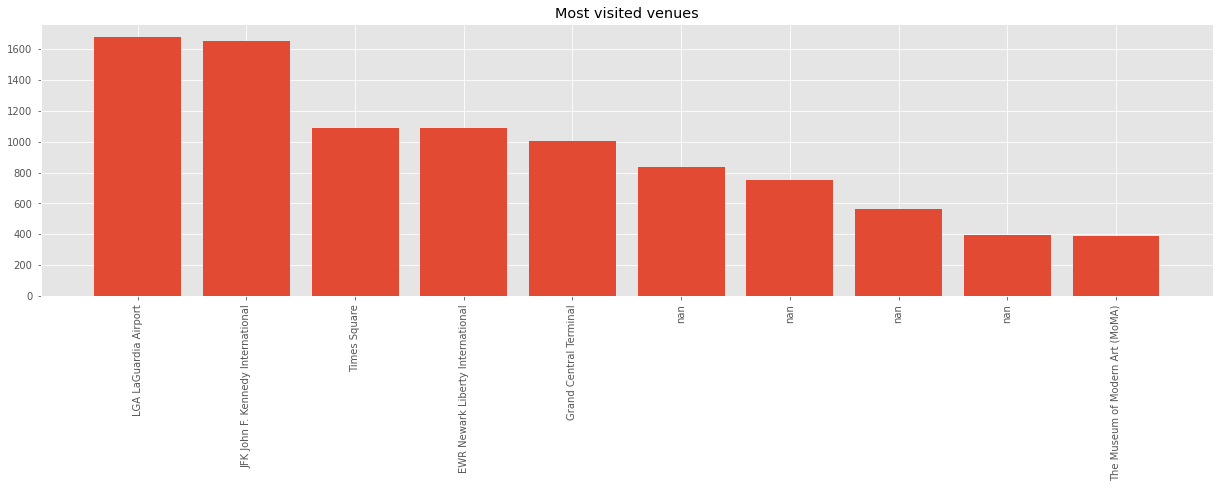

In [ ]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,5)

plt.bar(range(len(topvenues)), topvenues['count'], align='center')
plt.xticks(range(len(topvenues)),topvenues['spotname'], rotation='vertical')
plt.title('Most visited venues')
plt.show()

In [ ]:
def recommend_venues(df, longitude, latitude):
    predicted_cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    # Fetch the venue name of the top most record in the topvenues dataframe for the predicted cluster
    venue_name = df[df['cluster']==predicted_cluster].iloc[0]['spotname']
    msg = 'What about buying this Product ' + str(venue_name) + '?'
    return msg

In [ ]:
#Predictions

In [ ]:
recommend_venues(topvenues_df, -74, 40.55)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


'What about buying this Product Coney Island Boardwalk?'

In [ ]:
recommend_venues(topvenues, -73.993, 40.75)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


'What about buying this Product nan?'